## *Forecasting sales*

<img src="forecast.webp" alt="forecast-sales" width="350">

*`Forecast`*

Forecasting sales is crucial in revenue and pricing strategy because it helps businesses plan effectively for the future, for exmaple: 

- *Strategic Resource Allocation:* By anticipating future sales, businesses can allocate resources, this ensures that they have the necessary resources in place to meet demand without overcommitting or underutilizing resources.<br><br>

- *Price Optimization:* Understanding future sales trends allows businesses to set prices strategically. We can adjust prices based on anticipated demand fluctuations, competitor actions, and market conditions to maximize revenue and profitability.<br><br>

- *Market Expansion Strategies:* Sales forecasts provide valuable insights into potential market opportunities and growth areas. Businesses can use this information to identify new target markets or launch new products in line with projected demand.<br><br>

- *Risk Mitigation:* By forecasting sales, businesses can identify potential risks and uncertainties in their revenue streams. This enables them to develop contingency plans and mitigation strategies to address potential challenges and minimize their impact on business operations.<br><br>

- *Performance Evaluation:* Sales forecasts serve as benchmarks against which actual performance can be measured. By comparing actual sales figures to forecasted values, businesses can evaluate the effectiveness of their strategies, identify areas for improvement, and make necessary adjustments to enhance future performance.<br><br>

`packages`

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# stas models
import statsmodels.api as sm
from statsmodels.stats import descriptivestats
from pylab import rcParams

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# warnings
import warnings
warnings.filterwarnings('ignore')

# scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# skforecast
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# shap values
import shap
shap.initjs()

# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

`get data`

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select
            *
    from
            kaggle_data.price_optimization.data_gas_station;
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day
1,2019-06-09,9,6,2019,diesel,16,100.000,1,100.000,21.09,26.1,7,1,normal day
2,2019-06-09,9,6,2019,diesel,19,9.483,1,9.483,21.09,26.1,7,1,normal day


The initial step involves delving deep into the data and scrutinizing various aspects. The foremost task is to ascertain whether the data contains any null values and the info about it.

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21465 non-null  datetime64[ns]
 1   day           21465 non-null  int64         
 2   month         21465 non-null  int64         
 3   year          21465 non-null  int64         
 4   product       21465 non-null  object        
 5   hour          21465 non-null  int64         
 6   volume        21465 non-null  float64       
 7   transactions  21465 non-null  int64         
 8   avg_by_tkt    21465 non-null  float64       
 9   price         21465 non-null  float64       
 10  raining_days  21465 non-null  float64       
 11  weekday       21465 non-null  int64         
 12  is_weekend    21465 non-null  int64         
 13  holiday_name  21465 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(7), object(2)
memory usage: 2.3+ MB


In [7]:
df_raw.isnull().sum()

date            0
day             0
month           0
year            0
product         0
hour            0
volume          0
transactions    0
avg_by_tkt      0
price           0
raining_days    0
weekday         0
is_weekend      0
holiday_name    0
dtype: int64

In [8]:
df_raw['covid']=np.where(df_raw['date']>'2020-03-20', 1, 0)
df_raw.head(1)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0


In [9]:
df=df_raw.copy()
df.head(2)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0
1,2019-06-09,9,6,2019,diesel,16,100.000,1,100.000,21.09,26.1,7,1,normal day,0


In [10]:
# select only the regular product
df=df[df['product']=='regular']

To enhance sales forecasting, we'll first accumulate sales data by the hour. As depicted in the chart below, the majority of sales typically occur during daylight hours, reflecting a common pattern. Additionally, our observations indicate that the bulk of sales are made prior to 10 p.m.

In [11]:
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
df['hour'] = pd.to_timedelta(df['hour'], unit='h')
df['date']=df['date']+df['hour']
df.drop(columns='hour', inplace=True)
df=df.set_index('date')
df=df.sort_index()
df.head(2)

,day,month,year,product,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
date,,,,,,,,,,,,,
2019-06-09 06:00:00,9,6,2019,regular,84.356,5,16.871200,19.59,26.1,7,1,normal day,0
2019-06-09 07:00:00,9,6,2019,regular,124.675,12,10.389583,19.59,26.1,7,1,normal day,0


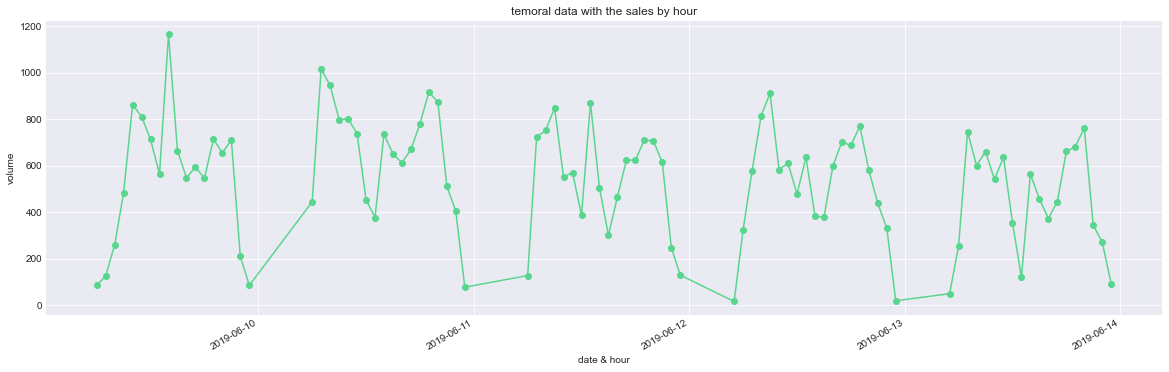

In [12]:
condition=df.index<='2019-06-13 23:59:59'

plt.figure(figsize=(20, 6))
plt.plot(df.index[condition], df['volume'][condition], marker='o', linestyle='-', color='#58D68D')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

One crucial step in addressing prediction problems is to validate the presence of missing values. In the current scenario, there are no missing values detected. However, when they do occur, it's essential to comprehend the data's behavior to determine the most suitable imputation strategy. For instance, we may opt for methods like mean or median imputation based on the data's distribution and characteristics.

In [13]:
df.isnull().sum()

day             0
month           0
year            0
product         0
volume          0
transactions    0
avg_by_tkt      0
price           0
raining_days    0
weekday         0
is_weekend      0
holiday_name    0
covid           0
dtype: int64

`split the data`

Before commencing our analysis, it is imperative to ensure that all data points are accounted for. In light of any missing hours within our dataset, we will implement an imputation strategy aimed at maintaining data integrity. 

Specifically, this strategy entails replicating the next valid data point in place of any missing values for the features under consideration. By adopting this approach, we aim to minimize data gaps and ensure a comprehensive dataset for our analysis.

In [14]:
start=df_raw['date'].min()
end=df_raw['date'].max()

In [15]:
dates=pd.DataFrame(pd.date_range(start=start,
                                 end=end, 
                                 freq='H'), columns=['date-complete'])

In [16]:
df=dates.merge(df, left_on='date-complete', right_on=df.index, how='left')
df.head(7)

,date-complete,day,month,year,product,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
0,2019-06-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-09 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-09 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-09 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-09 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-06-09 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-06-09 06:00:00,9.0,6.0,2019.0,regular,84.356,5.0,16.8712,19.59,26.1,7.0,1.0,normal day,0.0


drop columns

In [17]:
cols=['year', 'product']
df.drop(columns=cols, inplace=True)
df.head(1)

,date-complete,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
0,2019-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before beginning, we must address the missing values. For some, we'll assign a scalar value, while for others, we'll set them to the next valid value.

In [18]:
# set a value
df['volume'].fillna(value=0, inplace=True)         # volume
df['transactions'].fillna(value=0, inplace=True)   # transactions
df['avg_by_tkt'].fillna(value=0, inplace=True)     # average sold by transaction

# set a method
df['price'].fillna(method='backfill', inplace=True)              # price
df['raining_days'].fillna(method='backfill', inplace=True)       # number of raining days during the month
df['weekday'].fillna(method='backfill', inplace=True)            # day of the week
df['is_weekend'].fillna(method='backfill', inplace=True)         # flag to know when is weeknd
df['holiday_name'].fillna(method='backfill', inplace=True)       # holiday name, if apply
df['covid'].fillna(method='backfill', inplace=True)              # covid

In [19]:
df.rename(columns={'date-complete':'date'}, inplace=True)
df.set_index('date', drop=True,inplace=True)
df.head(2)

,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid
date,,,,,,,,,,,
2019-06-09 00:00:00,NaN,NaN,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0
2019-06-09 01:00:00,NaN,NaN,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0


In [20]:
# hour, day & month
df['hour']=df.index.hour
df['day']=df.index.day
df['month']=df.index.month
df.head(2)

,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid,hour
date,,,,,,,,,,,,
2019-06-09 00:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,0
2019-06-09 01:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,1


Now that we have all the data, we assume that sales are zero during the completion period.

As depicted in the graph below, we can mitigate the fluctuations in the data, allowing for a clearer observation of patterns. Specifically, we can now discern instances where sales register as zero due to a lack of traffic—a phenomenon that is quite common in retail settings. This enhanced clarity enables us to better understand and contextualize the dynamics between sales and foot traffic, thereby facilitating more informed decision-making processes.

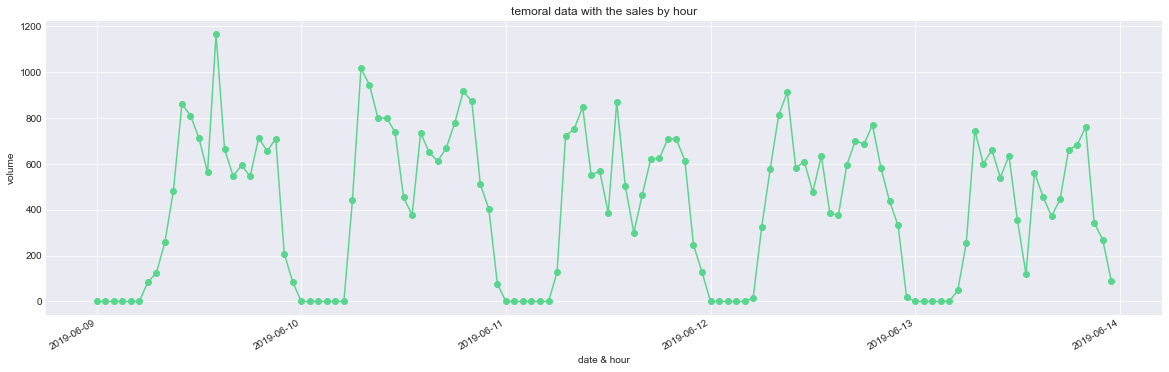

In [21]:
condition=df.index<='2019-06-13 23:59:59'

plt.figure(figsize=(20, 6))
plt.plot(df.index[condition], df['volume'][condition], marker='o', linestyle='-', color='#58D68D')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

In [22]:
print('start date: ', df.index.min())
print('end date: ', df.index.max())

start date:  2019-06-09 00:00:00
end date:  2020-08-30 00:00:00


Currently, we're aiming to divide the data into training, validation, and testing sets. Instead of relying on the split functionality provided by scikit-learn, we're opting for a custom approach due to the temporal nature of the problem. 

Shuffling the data could lead to leakage, potentially causing our model to overfit.

In [23]:
end_train = '2020-05-31 00:00:00'
end_validation = '2020-07-31 23:59:00'

df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"train dates: {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"validation dates: {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"test dates: {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

train dates: 2019-06-09 00:00:00 --- 2020-05-31 00:00:00  (n=8571)
validation dates: 2020-05-31 00:00:00 --- 2020-07-31 23:00:00  (n=1488)
test dates: 2020-08-01 00:00:00 --- 2020-08-30 00:00:00  (n=697)


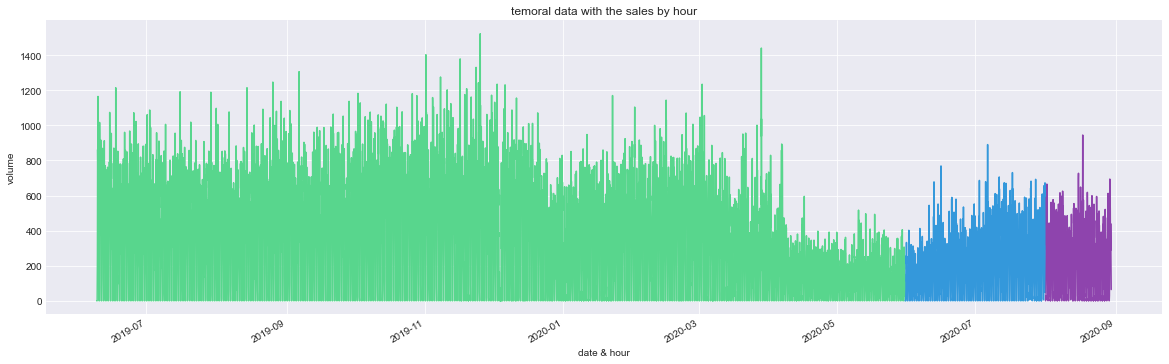

In [24]:
plt.figure(figsize=(20, 6))
plt.plot(df_train.index, df_train['volume'], color='#58D68D')
plt.plot(df_val.index, df_val['volume'], color='#3498DB')
plt.plot(df_test.index, df_test['volume'], color='#8E44AD')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

As depicted in the following charts, there are instances of zero sales during certain hours, which is quite unusual. This anomaly likely stems from the absence of transactions throughout the day, as indicated by the trend. Moreover, the seasonal patterns in the chart suggest a recurring dip in sales at specific intervals.

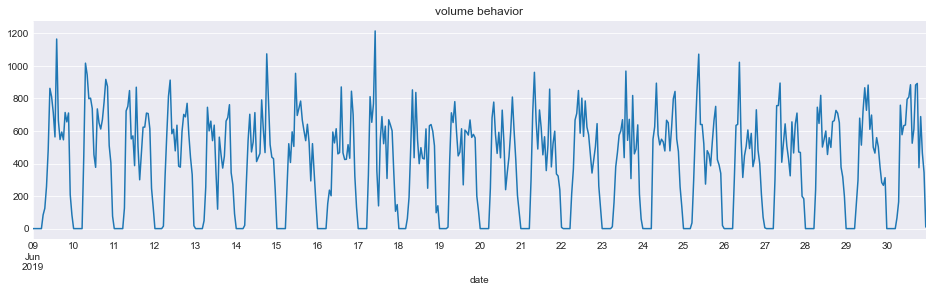

In [25]:
condition=df.index<='2019-06-30 23:59:59'
y=df['volume'][condition].resample('H').sum()

# plot data
y.plot(figsize = (16,4))
plt.title('volume behavior')
plt.show()

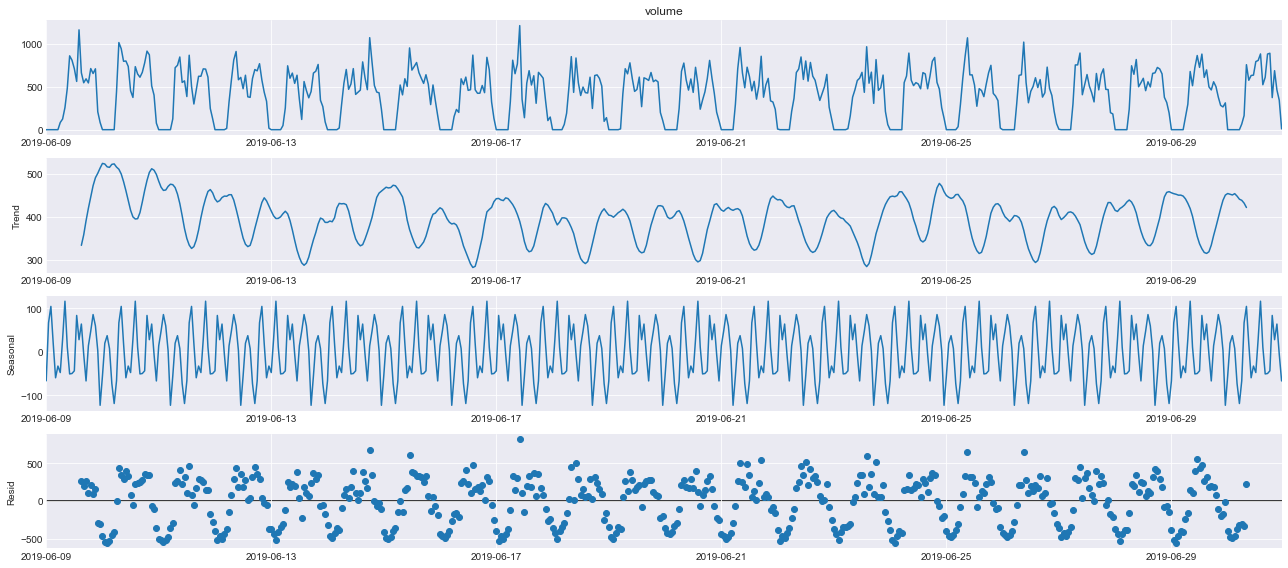

In [26]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, period = 30)
fig = decomposition.plot()
plt.show()

Upon examination of the autocorrelation chart, it becomes evident that there is a positive correlation or association between the sales of a given hour and the preceding hours. Additionally, there is a correlation observed between the sales at a specific hour and the sales during the same hour on previous days.

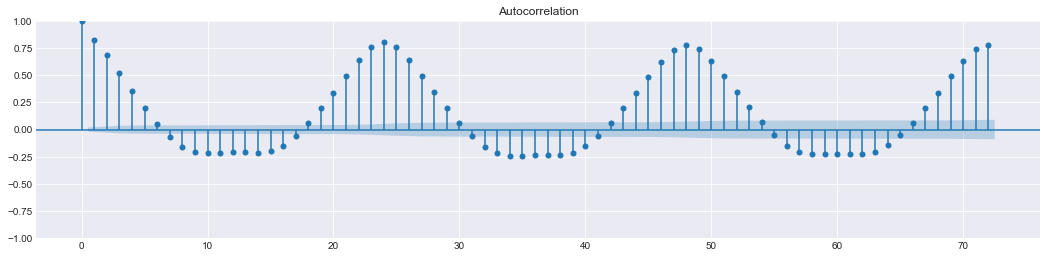

In [27]:
fig, ax = plt.subplots(figsize=(18, 4))
plot_acf(df['volume'], ax=ax, lags=72)
plt.show()

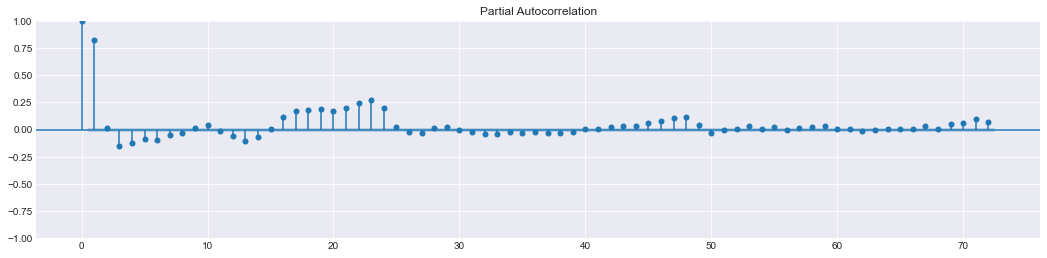

In [28]:
fig, ax = plt.subplots(figsize=(18, 4))
plot_pacf(df['volume'], ax=ax, lags=72)
plt.show()

`baseline`

At this stage, our primary focus is on establishing a baseline for our sales forecasting efforts. This baseline serves as a fundamental reference point, providing a straightforward method for projecting future sales trends. In our particular scenario, we will adopt a naive forecasting approach, leveraging past sales data to inform our predictions. By implementing this method, we aim to establish a foundational understanding of sales patterns, laying the groundwork for more sophisticated forecasting methodologies in the future.

`naive forecast`


A *naive forecast* is like making a simple guess about the future based only on what happened in the past. Imagine you're trying to predict tomorrow's weather by saying it will be the same as today. That's a naive forecast—it assumes that nothing unexpected will happen to change things. In sales, a naive forecast might mean predicting that tomorrow's sales will be the same as today's. It's a basic method that doesn't take into account any complex factors, but it can still give us a starting point for our predictions.

In [29]:
def seasonal_naive_forecast(data, seasonality):
    forecasts = []
    for i in range(len(data)):
        forecast = data[i - seasonality]
        forecasts.append(forecast)
    return forecasts

df_val['forecast']=seasonal_naive_forecast(df_val['volume'], 24)

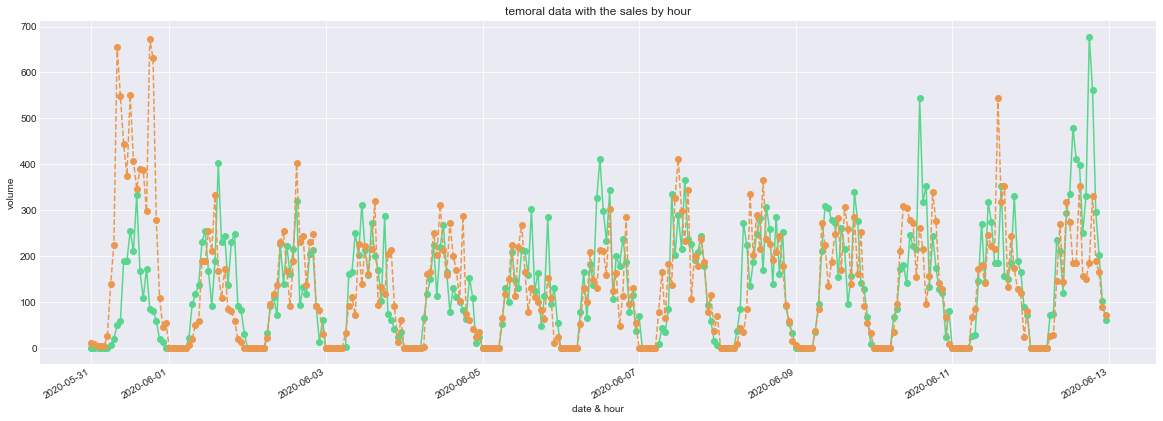

In [30]:
condition=df_val.index<='2020-06-12 23:59:59'

plt.figure(figsize=(20, 7))
plt.plot(df_val.index[condition], df_val['volume'][condition], marker='o', linestyle='-', color='#58D68D')
plt.plot(df_val.index[condition], df_val['forecast'][condition], marker='o', linestyle='--', color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

In [31]:
df_val['abs_error']=np.abs(df_val['forecast']-df_val['volume'])
print('MAE: ', np.mean(df_val['abs_error']))
print('mean volume: ', np.mean(df_val['volume']))

MAE:  77.65573387096774
mean volume:  197.51084072580645


In assessing our baseline model, one crucial factor to consider is the baserate, which serves as a benchmark for evaluating our predictive performance. In our current context, the baserate is represented by our Mean Absolute Error (MAE), standing at 77.65. Essentially, this means that, on average, our predictions deviate from the actual values by approximately 77.65 units. Our goal, therefore, is to refine our baseline model to achieve an MAE below this threshold, thereby enhancing its predictive accuracy and outperforming the baserate. This serves as a pivotal step in our quest to develop more robust forecasting models.

*drop columns*

In [32]:
df_val.drop(columns=['forecast', 'abs_error'], inplace=True)

`skforecast`<br><br>
As we progress to the next phase of refining our predictions, we're excited to introduce SKForecaster into our toolkit. SKForecaster is a powerful tool designed for generating forecasts based on data analysis. Think of it as a modern-day crystal ball, but for numbers! By feeding SKForecaster with relevant data—such as historical sales figures or weather patterns—we can harness its predictive capabilities to anticipate future outcomes. Whether it's aiding businesses in strategic planning or assisting meteorologists in forecasting the weather for the next day, SKForecaster simplifies the process by handling all the intricate calculations behind the scenes. All you have to do is input your data, sit back, and let SKForecaster work its magic, providing valuable insights into what lies ahead.

`LGBM (light gradient-boosting machine)`

LGBM Regressor is like a super-smart calculator for predicting numbers. It stands for Light GBM Regressor, which is a type of machine learning algorithm.

*Here's how it works: Imagine you have a bunch of data about something, like house prices. You give this data to the LGBM Regressor, and it learns from it. It looks for patterns in the data, like how the number of bedrooms or the neighborhood might affect the price of a house.Once it learns these patterns, you can then ask it to predict the price of a new house based on similar information. So if you tell it how many bedrooms and bathrooms a house has, it can give you an estimate of how much that house might cost.*

The "light" part of LGBM Regressor means it's designed to be really fast and efficient, even with a lot of data. So it's great for making quick predictions, which can be super helpful for all sorts of things like predicting sales, stock prices, or even medical outcomes.

In [33]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )
             

forecaster.fit(y=df.loc[:end_train, 'volume'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8570] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-26 13:43:32 
Last fit date: 2024-04-26 13:43:3

In [34]:
metric, predictions=backtesting_forecaster(forecaster= forecaster,
                                           y = df['volume'].reset_index(drop=True),
                                           steps = 24,
                                           metric = 'mean_squared_error',
                                           initial_train_size = len(df.loc[:end_train]),
                                           fixed_train_size = False,
                                           gap = 0,
                                           allow_incomplete_fold = True,
                                           refit = True,
                                           verbose = True,
                                           show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8571
Number of observations used for backtesting: 2184
    Number of folds: 91
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 8570  (n=8571)
    Validation: 8571 -- 8594  (n=24)
Fold: 1
    Training:   0 -- 8594  (n=8595)
    Validation: 8595 -- 8618  (n=24)
Fold: 2
    Training:   0 -- 8618  (n=8619)
    Validation: 8619 -- 8642  (n=24)
Fold: 3
    Training:   0 -- 8642  (n=8643)
    Validation: 8643 -- 8666  (n=24)
Fold: 4
    Training:   0 -- 8666  (n=8667)
    Validation: 8667 -- 8690  (n=24)
Fold: 5
    Training:   0 -- 8690  (n=8691)
    Validation: 8691 -- 8714  (n=24)
Fold: 6
    Training:   0 -- 8714  (n=8715)
    Validation: 8715 -- 8738  (n=24)
Fold: 7
    Training:   0 -- 8738  (n=8739)
    Validation: 8739 -- 8762  (n=24)
Fold: 8
    Training:   0 -- 8762  (

  0%|          | 0/91 [00:00<?, ?it/s]

In our analysis, we've observed that the Mean Absolute Error (MAE) from the forecast slightly exceeds that of the baseline. Before determining which model to employ, it's imperative to engage in fine-tuning. Presently, the MAE from the baseline appears satisfactory, highlighting its advantage, particularly in scenarios involving seasonal data. However, our current objective leans towards a more refined approach, leveraging the capabilities of the skforecast framework. This decision underscores our commitment to optimizing forecast accuracy and precision.

In [35]:
print(f'error backtesting: {round(metric, 2)}')

error backtesting: 11061.81


In [36]:
real_data=df['volume'].reset_index(drop=False)
real_data=real_data[real_data.index>8570]
real_data.head(1)

,date,volume
8571,2020-05-31 01:00:00,0.0


In [37]:
pre_real_data=real_data.merge(predictions, left_index=True, right_index=True)
pre_real_data.head(2)

,date,volume,pred
8571,2020-05-31 01:00:00,0.0,16.004964
8572,2020-05-31 02:00:00,0.0,12.728326


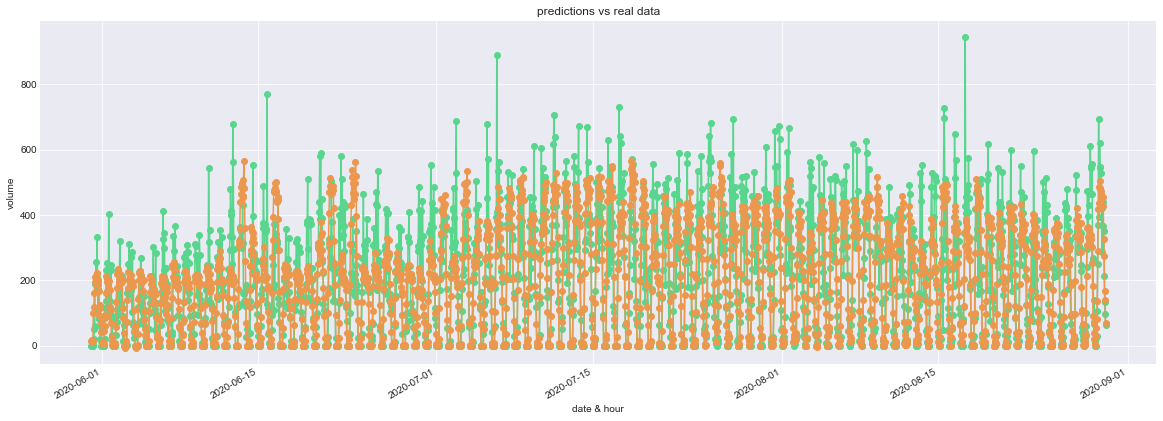

In [38]:
plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'], 
         pre_real_data['volume'], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'], 
         pre_real_data['pred'], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('predictions vs real data')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

As depicted in the following chart, the model's accuracy may not be optimal. However, upon closer examination of the forecast, we observe variations that provide insights into the sales behavior. Overall, the model adheres to the sales trend, albeit with some deviations. While it generally captures the essence, there are instances where enhanced accuracy would be beneficial.

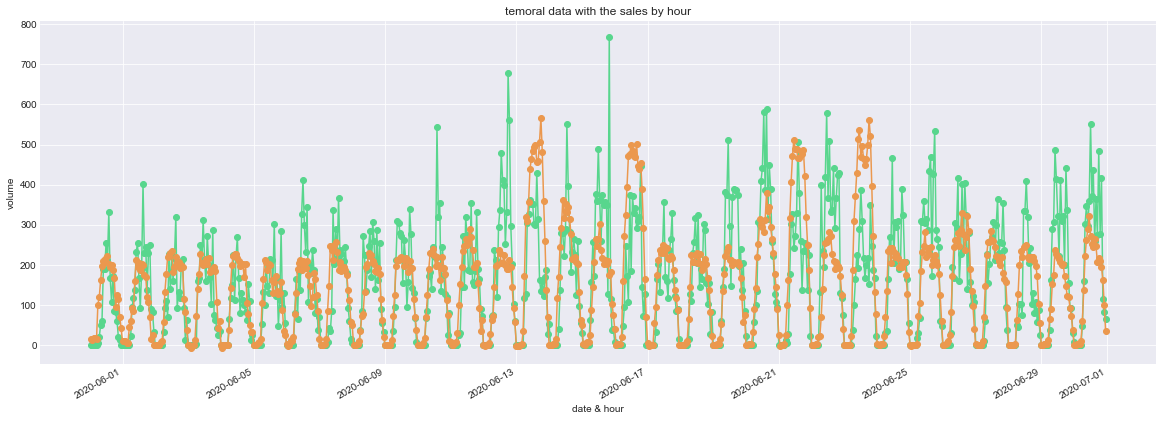

In [39]:
condition=pre_real_data['date']<='2020-06-30 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

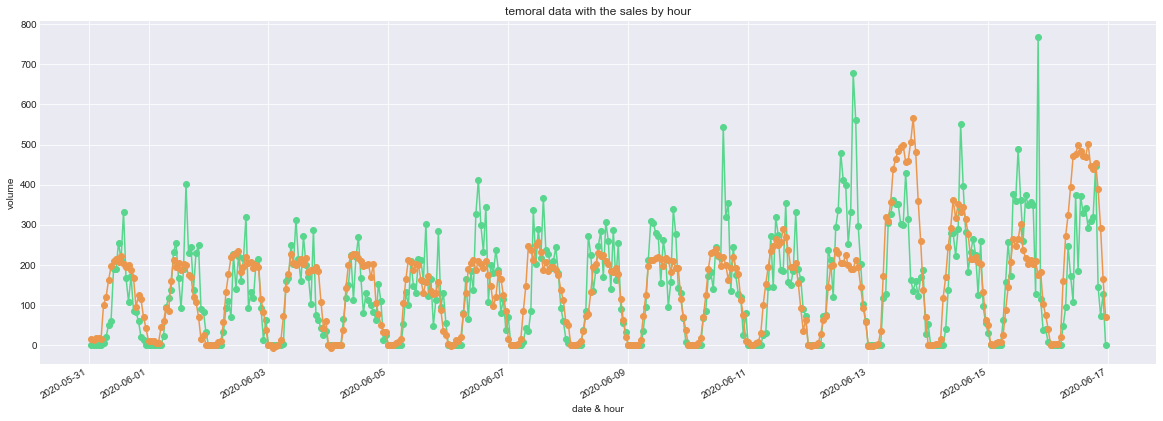

In [40]:
condition=pre_real_data['date']<='2020-06-16 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

In our pursuit of enhancing the accuracy of our forecasting model, we are delving into fine-tuning techniques. This involves experimenting with various hyperparameters to optimize the performance of our model. Through meticulous exploration and iteration, we aim to identify the most effective combination of hyperparameters that yield the best results. Once we've sifted through the options and conducted thorough evaluations, we'll select the top-performing model from the pool of candidates generated. This meticulous process ensures that we deploy the most refined and accurate forecasting model, ultimately empowering us to make more informed decisions based on reliable predictions.

In [41]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24, 
             )


lags_grid = [24, [12, 24, 36, 48, 72]]


def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        #'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        #'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

search_results, frozen_trial = bayesian_search_forecaster(
                                        forecaster         = forecaster,
                                        y                  = df['volume'].reset_index(drop=True),
                                        steps              = 24,
                                        metric             = 'mean_absolute_error',
                                        search_space       = search_space,
                                        lags_grid          = lags_grid,
                                        initial_train_size = len(df[:end_train]),
                                        refit              = True,
                                        n_trials           = 10, 
                                        random_state       = 42,
                                        return_best        = True,
                                        verbose            = False)

Number of models compared: 20,
         10 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.03276070223279889}
  Backtesting metric: 71.42971135228919



In [42]:
search_results

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 900, 'max_depth': 7, 'learnin...",71.429711,900.0,7.0,0.032761
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 4, 'learni...",71.541559,1000.0,4.0,0.086437
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1100, 'max_depth': 4, 'learni...",72.689166,1100.0,4.0,0.099094
19,"[12, 24, 36, 48, 72]","{'n_estimators': 900, 'max_depth': 7, 'learnin...",73.889518,900.0,7.0,0.032761
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 5, 'learnin...",74.729758,600.0,5.0,0.189517
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 900, 'max_depth': 9, 'learnin...",75.080803,900.0,9.0,0.107840
11,"[12, 24, 36, 48, 72]","{'n_estimators': 1000, 'max_depth': 4, 'learni...",75.107295,1000.0,4.0,0.086437
14,"[12, 24, 36, 48, 72]","{'n_estimators': 1100, 'max_depth': 4, 'learni...",75.468984,1100.0,4.0,0.099094
17,"[12, 24, 36, 48, 72]","{'n_estimators': 600, 'max_depth': 5, 'learnin...",77.857923,600.0,5.0,0.189517
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 5, 'learnin...",78.139787,700.0,5.0,0.267131


In [43]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.03276070223279889, max_depth=7, n_estimators=900,
              random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 10754] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03276070223279889, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 900, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verb

In [44]:
metric, predictions=backtesting_forecaster(forecaster= forecaster,
                                           y = df['volume'].reset_index(drop=True),
                                           steps = 24,
                                           metric = 'mean_squared_error',
                                           initial_train_size = len(df.loc[:end_train]),
                                           fixed_train_size = False,
                                           gap = 0,
                                           allow_incomplete_fold = True,
                                           refit = True,
                                           verbose = True,
                                           show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8571
Number of observations used for backtesting: 2184
    Number of folds: 91
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 8570  (n=8571)
    Validation: 8571 -- 8594  (n=24)
Fold: 1
    Training:   0 -- 8594  (n=8595)
    Validation: 8595 -- 8618  (n=24)
Fold: 2
    Training:   0 -- 8618  (n=8619)
    Validation: 8619 -- 8642  (n=24)
Fold: 3
    Training:   0 -- 8642  (n=8643)
    Validation: 8643 -- 8666  (n=24)
Fold: 4
    Training:   0 -- 8666  (n=8667)
    Validation: 8667 -- 8690  (n=24)
Fold: 5
    Training:   0 -- 8690  (n=8691)
    Validation: 8691 -- 8714  (n=24)
Fold: 6
    Training:   0 -- 8714  (n=8715)
    Validation: 8715 -- 8738  (n=24)
Fold: 7
    Training:   0 -- 8738  (n=8739)
    Validation: 8739 -- 8762  (n=24)
Fold: 8
    Training:   0 -- 8762  (

  0%|          | 0/91 [00:00<?, ?it/s]

Currently, our Mean Absolute Error (MAE) remains above the base rate. At this juncture, our forecasting efforts solely rely on sales data without incorporating additional variables.

In [45]:
print(f'error backtest (MAE): {metric}')
predictions.head(2)

error backtest (MAE): 10983.874320862207


,pred
8571,12.413793
8572,16.790011


In [46]:
real_data=df['volume'].reset_index(drop=False)
real_data=real_data[real_data.index>8570]
real_data.head(1)

,date,volume
8571,2020-05-31 01:00:00,0.0


In [47]:
pre_real_data=real_data.merge(predictions, left_index=True, right_index=True)
pre_real_data.head(2)

,date,volume,pred
8571,2020-05-31 01:00:00,0.0,12.413793
8572,2020-05-31 02:00:00,0.0,16.790011


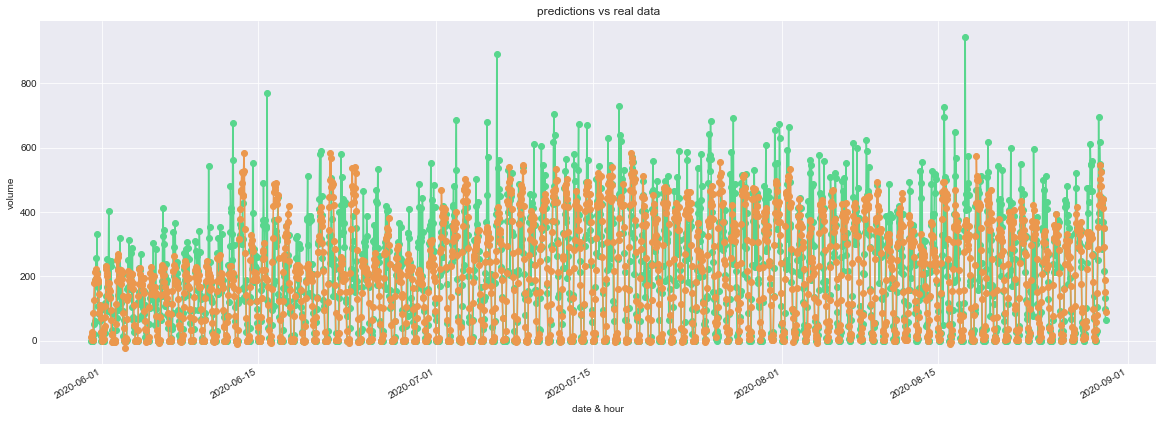

In [48]:
plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'], 
         pre_real_data['volume'], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'], 
         pre_real_data['pred'], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('predictions vs real data')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

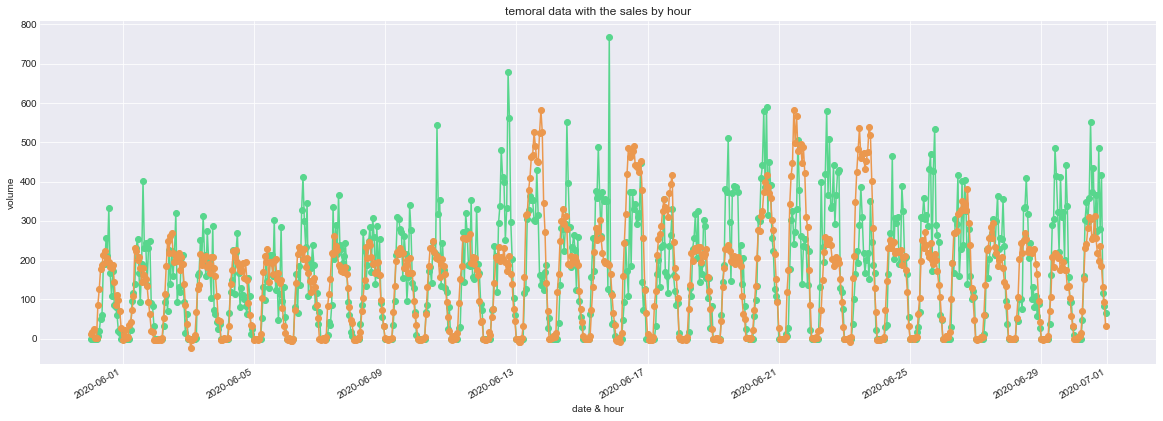

In [49]:
condition=pre_real_data['date']<='2020-06-30 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

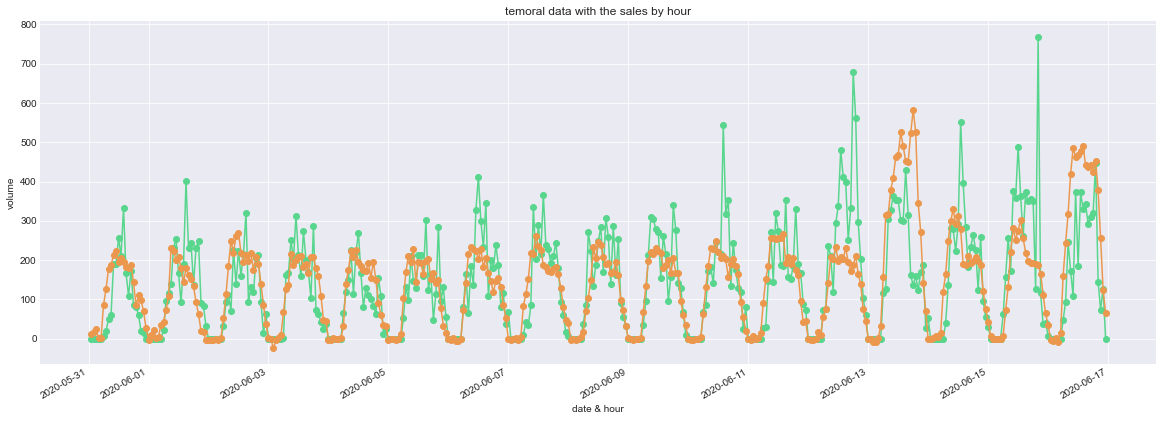

In [50]:
condition=pre_real_data['date']<='2020-06-16 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

As depicted in the charts above, although the MAE exceeds the base rate, the forecast appears promising. Nonetheless, there is room for improvement in refining our forecasting techniques.

In [51]:
# add holiday flag
df['holiday_flag']=np.where(df['holiday_name']!='normal day', 1, 0)
df.head(2)

,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid,hour,holiday_flag
date,,,,,,,,,,,,,
2019-06-09 00:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,0,0
2019-06-09 01:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,1,0


In [52]:
df_raw=df.copy()
df_raw.head(2)

,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,covid,hour,holiday_flag
date,,,,,,,,,,,,,
2019-06-09 00:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,0,0
2019-06-09 01:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,normal day,0.0,1,0


In [53]:
# drop columns
df.drop(columns=['holiday_name'], inplace=True)
df.head(2)

,day,month,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,covid,hour,holiday_flag
date,,,,,,,,,,,,
2019-06-09 00:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,0.0,0,0
2019-06-09 01:00:00,9,6,0.0,0.0,0.0,19.59,26.1,7.0,1.0,0.0,1,0


In [54]:
params = {'n_estimators': 1100,
          'max_depth': 10,
          'learning_rate': 0.0327,
          'reg_alpha': 0.8,
          'reg_lambda': 0.2,
          'random_state':42,
          'verbose': -1}

forecaster = ForecasterAutoreg(regressor = LGBMRegressor(**params), 
                               lags = 24)

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.0327, max_depth=10, n_estimators=1100,
              random_state=42, reg_alpha=0.8, reg_lambda=0.2, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.0327, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.8, 'reg_lambda': 0.2, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': 

Now, with the aim of enhancing forecast accuracy, we've introduced additional exogenous variables. These variables are intended to assist the forecaster in identifying patterns and ultimately improving forecasting precision.

In [55]:
exog_features=['day', 'month', 'price', 'raining_days', 'weekday', 'is_weekend', 'covid', 'hour', 'holiday_flag']

In [56]:
metric, predictions = backtesting_forecaster(forecaster = forecaster,
                                             y = df['volume'].reset_index(drop=True),
                                             exog = df[exog_features].reset_index(drop=True),
                                             steps = 24,
                                             metric = 'mean_absolute_error',
                                             initial_train_size = len(df[:end_train]),
                                             refit = True,
                                             verbose = False,
                                             show_progress = True)

  0%|          | 0/91 [00:00<?, ?it/s]

Following the incorporation of new variables aimed at identifying patterns within the data, we've been able to refine the model significantly. Our efforts have resulted in achieving a Mean Absolute Error (MAE) of 63.4, surpassing the baseline rate of 77 and indicating notable improvement.

In [57]:
print(f'error backtest (MAE): {metric}')
predictions.head(2)

error backtest (MAE): 63.44264878984145


,pred
8571,-7.548371
8572,-6.994783


In [58]:
real_data=df['volume'].reset_index(drop=False)
real_data=real_data[real_data.index>8570]
real_data.head(1)

,date,volume
8571,2020-05-31 01:00:00,0.0


In [59]:
pre_real_data=real_data.merge(predictions, left_index=True, right_index=True)
pre_real_data.head(2)

,date,volume,pred
8571,2020-05-31 01:00:00,0.0,-7.548371
8572,2020-05-31 02:00:00,0.0,-6.994783


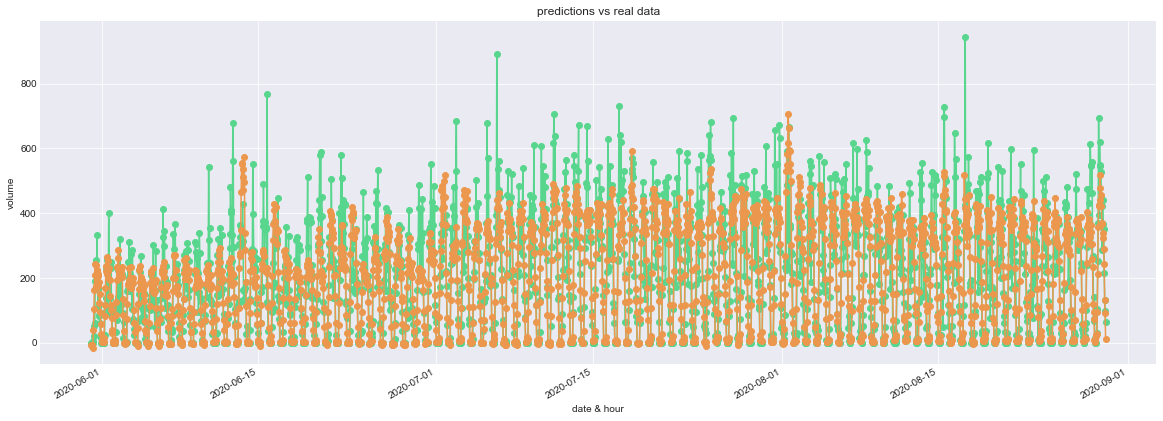

In [60]:
plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'], 
         pre_real_data['volume'], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'], 
         pre_real_data['pred'], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('predictions vs real data')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

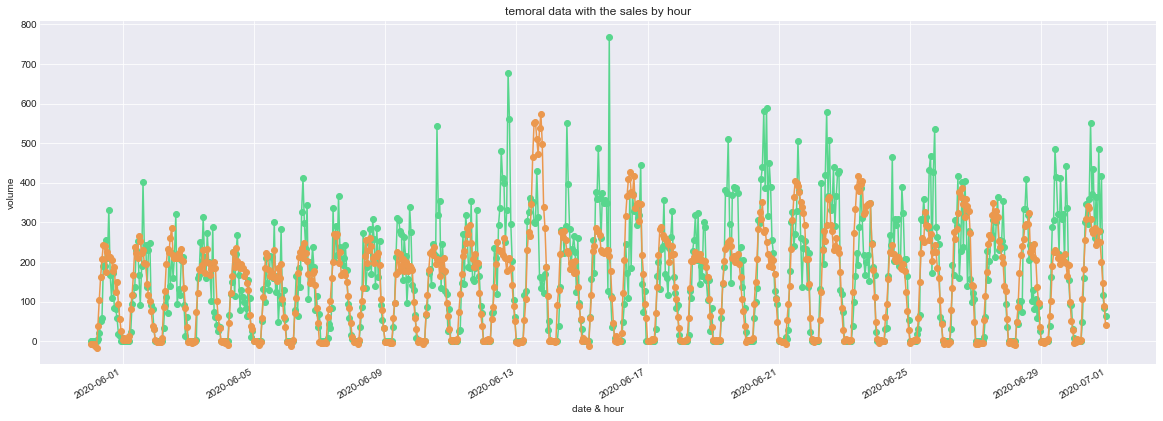

In [61]:
condition=pre_real_data['date']<='2020-06-30 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

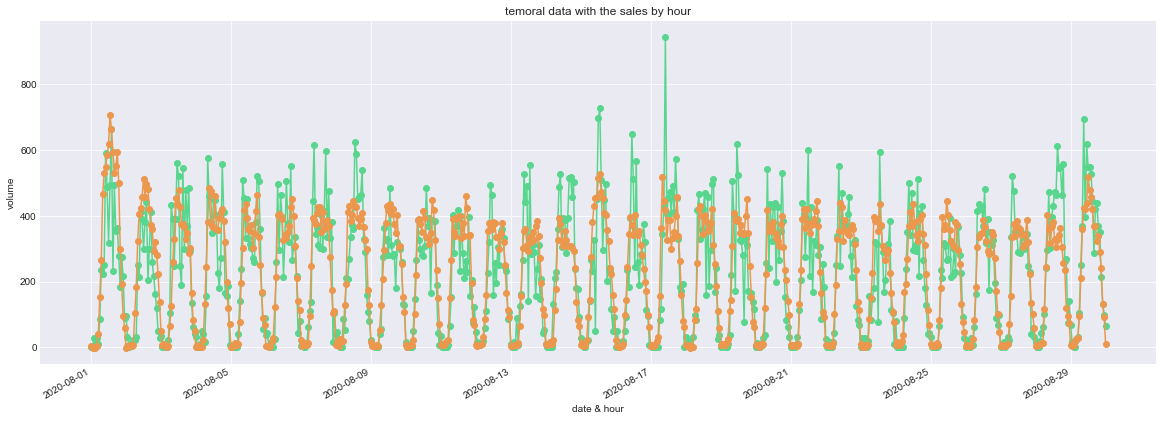

In [62]:
condition=pre_real_data['date']>='2020-07-31 23:59:59'

plt.figure(figsize=(20, 7))

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['volume'][condition], 
         marker='o', 
         linestyle='-', 
         color='#58D68D')

plt.plot(pre_real_data['date'][condition], 
         pre_real_data['pred'][condition], 
         marker='o', 
         linestyle='-', 
         color='#EB984E')

plt.title('temoral data with the sales by hour')
plt.xlabel('date & hour')
plt.ylabel('volume')
plt.grid(True)

plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.show()

In [63]:
lags_grid = [24, [12, 24, 36, 48, 72]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5)} 
    return search_space

search_results, frozen_trial = bayesian_search_forecaster(forecaster = forecaster,
                                                          y = df['volume'].reset_index(drop=True),
                                                          search_space = search_space,
                                                          steps = 24,
                                                          metric = 'mean_absolute_error',
                                                          exog = df[exog_features].reset_index(drop=True),
                                                          initial_train_size = len(df[:end_train]),
                                                          lags_grid = lags_grid,
                                                          refit = True,
                                                          n_trials = 10,
                                                          random_state = 42,
                                                          return_best = True,
                                                          verbose = False)

Number of models compared: 20,
         10 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [12 24 36 48 72] 
  Parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.03276070223279889}
  Backtesting metric: 61.7048557115597



In [64]:
search_results.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate
19,"[12, 24, 36, 48, 72]","{'n_estimators': 900, 'max_depth': 7, 'learnin...",61.704856,900.0,7.0,0.032761
14,"[12, 24, 36, 48, 72]","{'n_estimators': 1100, 'max_depth': 4, 'learni...",62.629217,1100.0,4.0,0.099094
11,"[12, 24, 36, 48, 72]","{'n_estimators': 1000, 'max_depth': 4, 'learni...",62.649233,1000.0,4.0,0.086437


In [65]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.03276070223279889, max_depth=7, n_estimators=900,
              random_state=42, reg_alpha=0.8, reg_lambda=0.2, verbose=-1) 
Lags: [12 24 36 48 72] 
Transformer for y: None 
Transformer for exog: None 
Window size: 72 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['day', 'month', 'price', 'raining_days', 'weekday', 'is_weekend', 'covid', 'hour', 'holiday_flag'] 
Training range: [0, 10754] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03276070223279889, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 900, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.8, 'reg_lambda': 0

In [66]:
metric, predictions = backtesting_forecaster(forecaster = forecaster,
                                             y = df['volume'].reset_index(drop=True),
                                             exog = df[exog_features].reset_index(drop=True),
                                             steps = 24,
                                             metric = 'mean_absolute_error',
                                             initial_train_size = len(df[:end_train]),
                                             refit = True,
                                             verbose = False,
                                             show_progress = True)

  0%|          | 0/91 [00:00<?, ?it/s]

To further enhance the model's performance, we pursued fine-tuning adjustments. As a result of these efforts, our model experienced additional improvement, achieving a reduced Mean Absolute Error (MAE) of 61.7, surpassing our baseline rate. This outcome underscores the significant enhancement our model has undergone compared to its initial iteration.

In [67]:
print(f'error backtest (MAE): {metric}')

error backtest (MAE): 61.7048557115597


`SHAP (SHapley Additive exPlanations)`<br>

Our current aim is to identify the key features driving predictions in our model and assess their alignment with significant factors highlighted in our earlier causal analysis.

SHAP, short for SHapley Additive exPlanations, serves as a valuable tool in machine learning, offering insights into why a model produces specific predictions. Operating akin to assigning credit in team sports, SHAP assigns a "credit" to each feature in a prediction, indicating its contribution to the outcome. By illuminating the most influential features and their respective contributions, SHAP facilitates a deeper understanding and interpretation of complex machine learning models.

In [68]:
X, y = forecaster.create_train_X_y(y=df['volume'].reset_index(drop=True),
                                   exog = df[exog_features].reset_index(drop=True))

In [69]:
explainer=shap.TreeExplainer(forecaster.regressor)
shap_values=explainer.shap_values(X)

As illustrated in the chart below, certain variables such as hour, price, weekday, and holiday status emerge as robust predictors for the forecaster, consistent with findings from our earlier causal analysis.

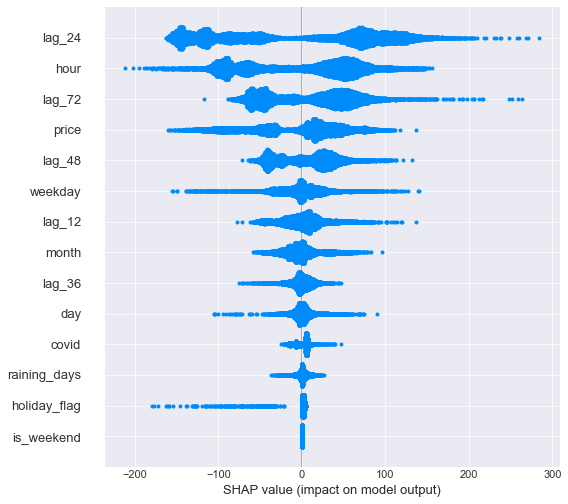

In [70]:
shap.summary_plot(shap_values=shap_values, 
                  feature_names=X.columns,
                  show=False)

In [75]:
shap.force_plot(explainer.expected_value, 
                shap_values[:250,:], 
                X.iloc[:250,:])

In [77]:
shap.force_plot(explainer.expected_value, 
                shap_values[16,:], 
                X.iloc[16,:])